<a href="https://colab.research.google.com/github/111221007/Awesome-Video-Object-Segmentation/blob/master/CNN_Accident_Detection_~91_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ckay16_accident_detection_from_cctv_footage_path = kagglehub.dataset_download('ckay16/accident-detection-from-cctv-footage')
fahaddalwai_cctvfootagevideo_path = kagglehub.dataset_download('fahaddalwai/cctvfootagevideo')

print('Data source import complete.')


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Setting up our Data  
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [5]:
batch_size = 100
img_height = 250
img_width = 250

The dataset that we are using has 3 different folders, and each of these have 2 folders within them having a folder for accident images and non accident images. Do look and scroll through them to verify and see the structure.  
In order to get our:  
1. train,
2. test
3. and validation split,  

we will use keras's inbuilt *image_dataset_from_directory()* function which is able to generate a tf dataset containing the images as well as their corresponding classes from the folder that we pass into the parameter.

In [6]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


Notice the output reading the files as well as the classes it recognises!  
Now, we'll set up a few performace parameters that will enhance runtime training of our model. I've learnt to use this from [this excellent notebook here](https://www.kaggle.com/code/vanvalkenberg/cnn-for-accident-detection-83-val-accuracy/notebook), so do check that out as well!

In [7]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Defining our Pre-Trained Model  
The next step is defining and creating our model. In order to increase accuracy and speed up training process, we'll go ahead and use a pre trained model for this task. Why you may ask?  This is because a pretrained convnet already has a very good idea of what features to look for in an image and can find them very effectively since it hs been trained on millions of images. So, if we can determine the presence of features all the rest of the model needs to do is determine which combination of features makes a specific image.  
So all we've to do is:
1. Define the base pretrained layer
2. Add final few layers that are specific to our function and task to enhance ability in those categories
3. Train our model!  
Lets use Googles MobileNetV2 for this purpose...


In [8]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

<ipython-input-8-ce0e22198566>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Notice how we set trainable to false in order to make sure model won’t make any changes to the weights of any layers that are already frozen during training.  
We also exclude the top of the model since we will perform classification on our own.

# Creating Final Model  
We now go ahead and create our final model which consists of the base model, and 3 more layers for performing convolution. The 2d output of the convolution layer is flattened and fed to a dense output layer to perform the classification.

In [9]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We'll let our model run for 50 epochs, which seems like a decent enough number. Increasing the epochs should result in an increase in accuracy uptil a certain point only though...

In [28]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 50)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.7873 - loss: 0.4807 - val_accuracy: 0.7653 - val_loss: 0.5031
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.8576 - loss: 0.3585 - val_accuracy: 0.8265 - val_loss: 0.4019
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.9144 - loss: 0.2373 - val_accuracy: 0.8469 - val_loss: 0.3259
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.9527 - loss: 0.1467 - val_accuracy: 0.8980 - val_loss: 0.2455
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.9768 - loss: 0.0883 - val_accuracy: 0.8776 - val_loss: 0.2548
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9871 - loss: 0.0549 - val_accuracy: 0.8878 - val_loss: 0.3376
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.9867 - loss: 0.0519 - val_accuracy: 0.8367 - val_loss: 0.6102
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.9740 - loss: 0.0663 - val_accuracy: 0.8878 - val_loss: 0.3731
Epoch 9/

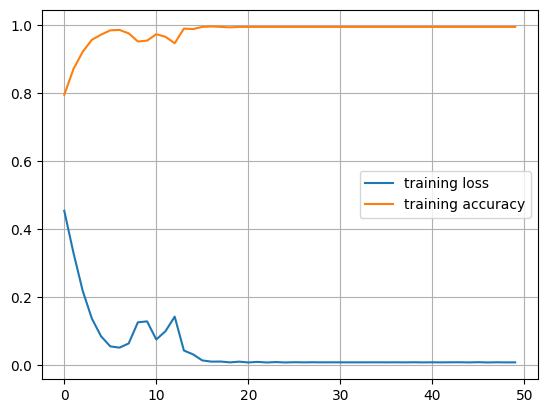

In [29]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

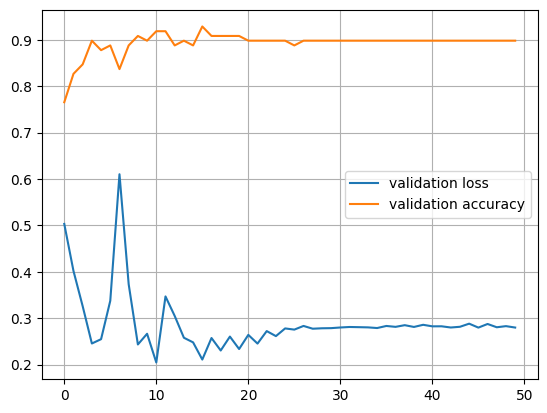

In [30]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

The function below looks a bit complicated, but is a simple helper function which shows the image, the predicted class and the actual class for each image in the test dataset. Run it and have a look at how accurate the model seems and where it seems to be struggling.

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


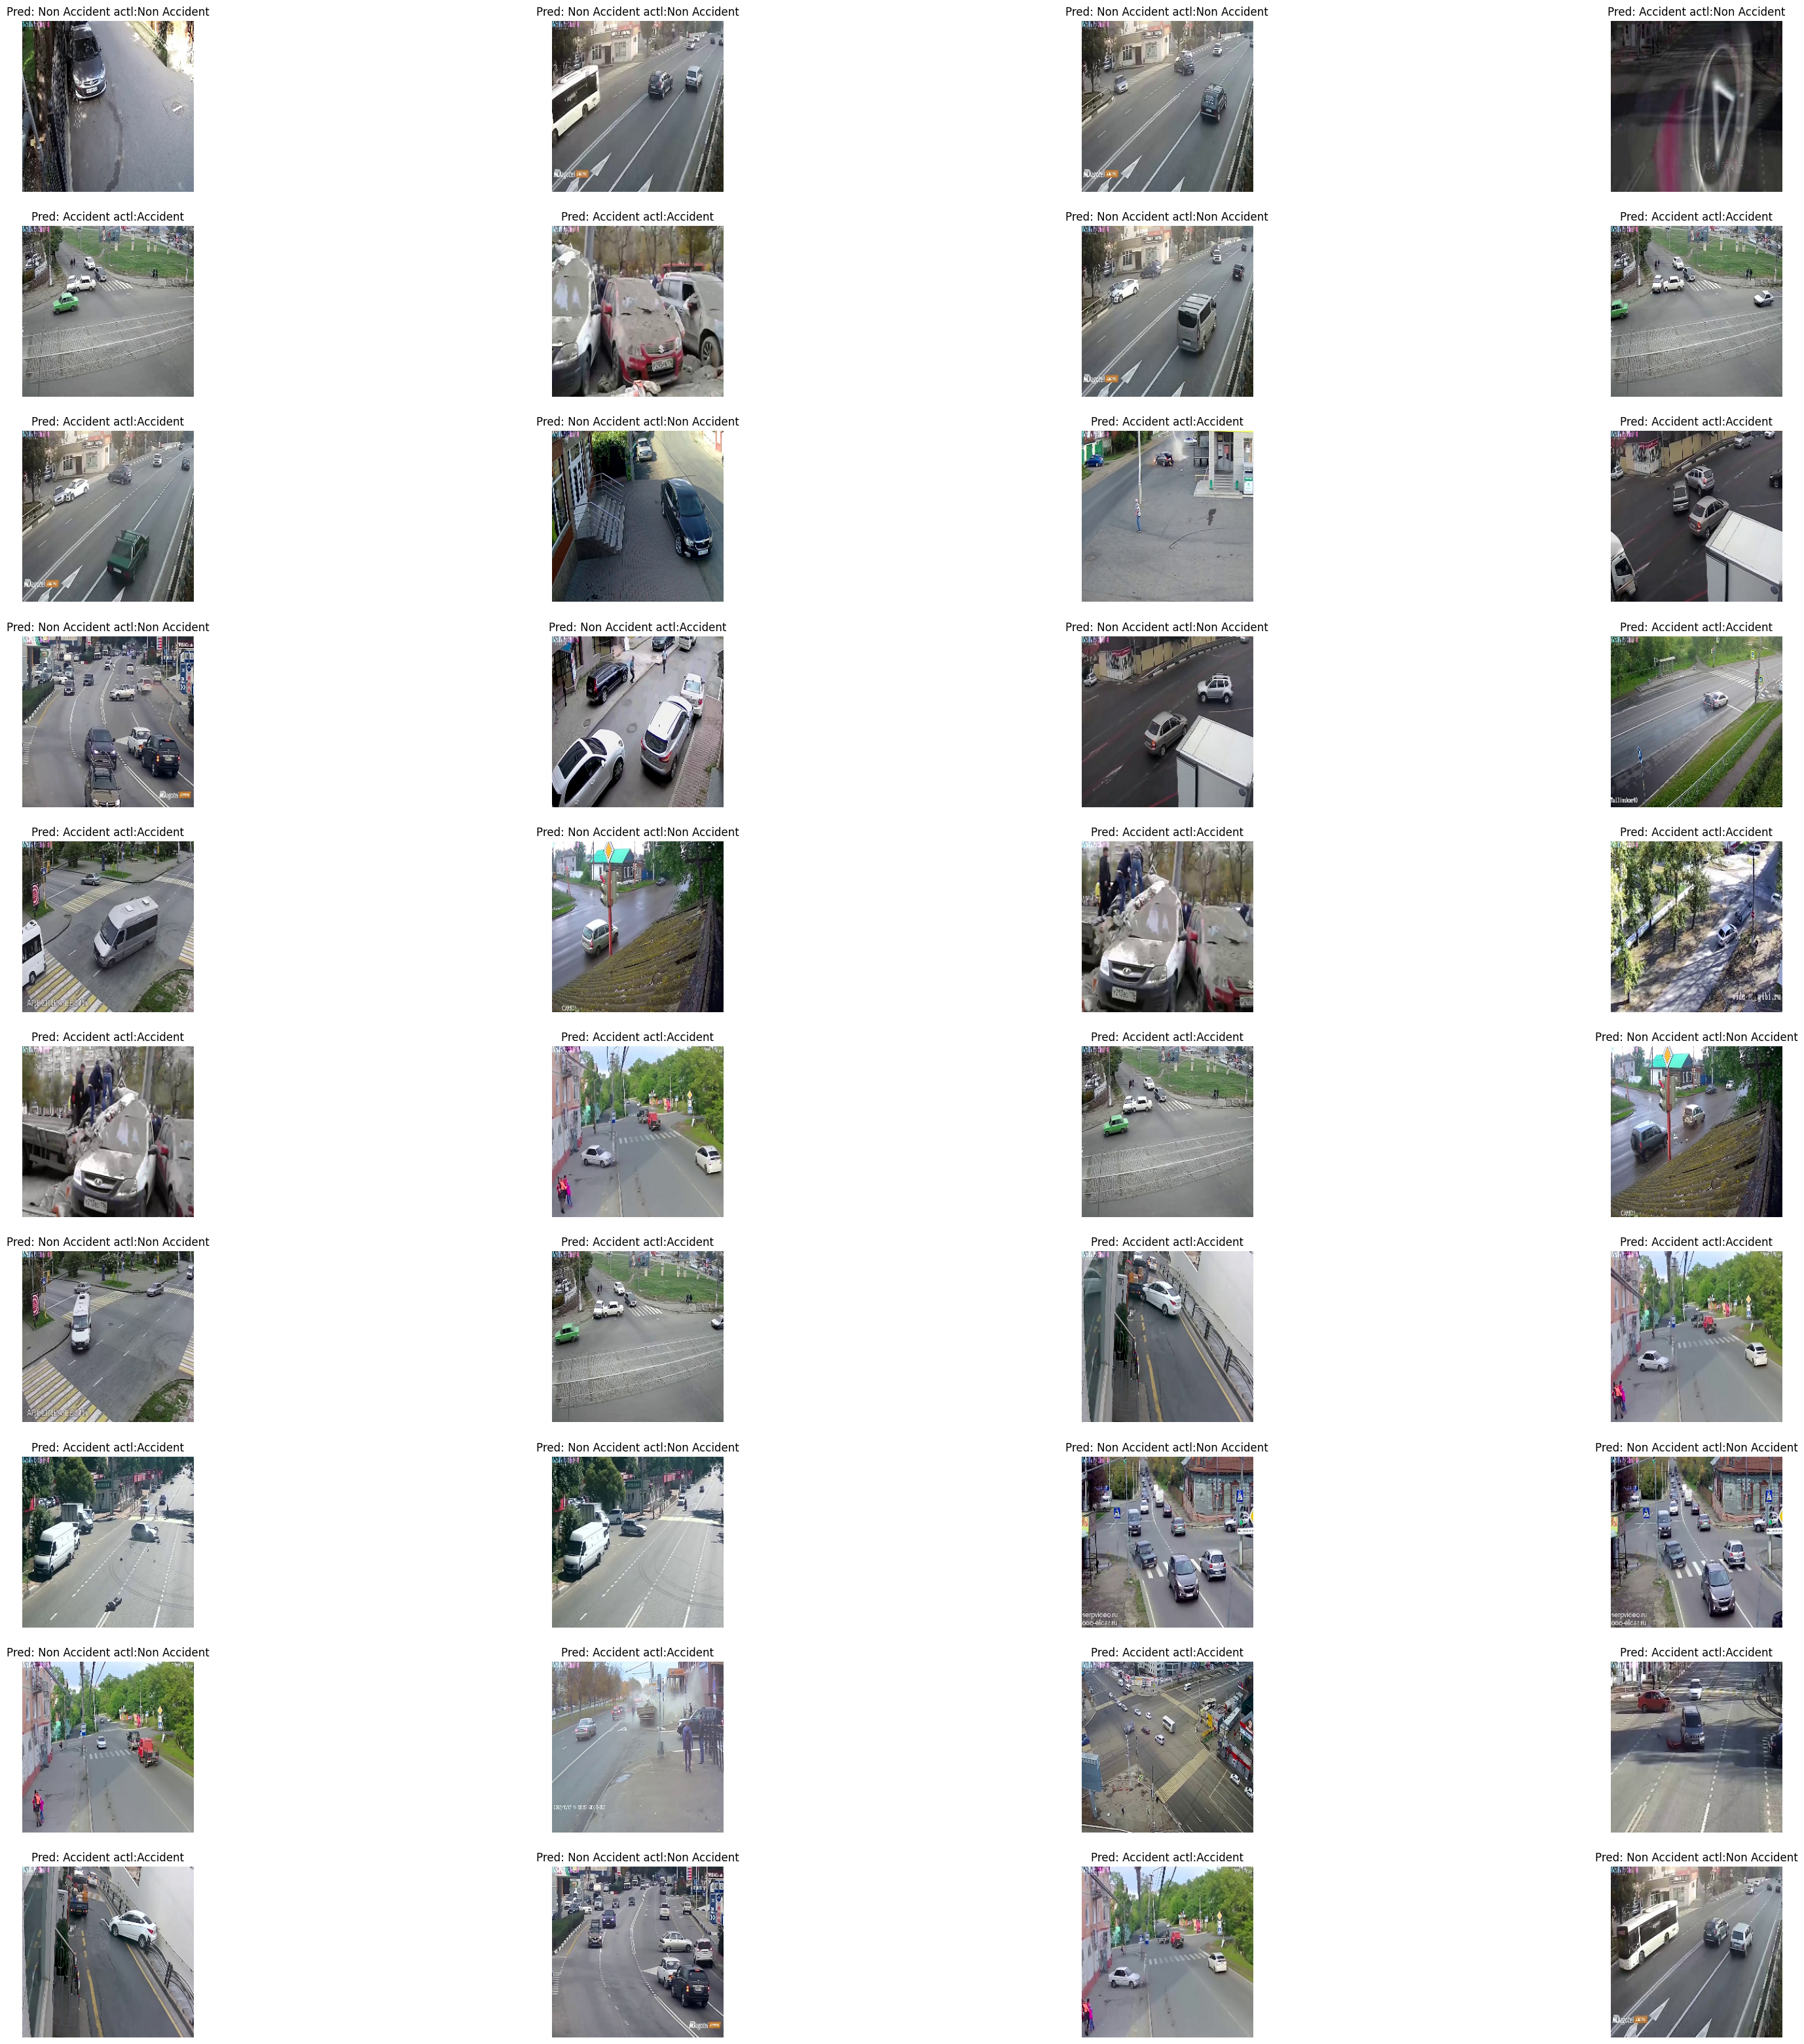

In [31]:
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [32]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive event is accident negative event is non accident
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [33]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 43
True negatives are: 49
False negatives are: 4
False positives are: 4


We can go ahead and view the models layers through the plot_model function below provided by keras for an intuitive view.

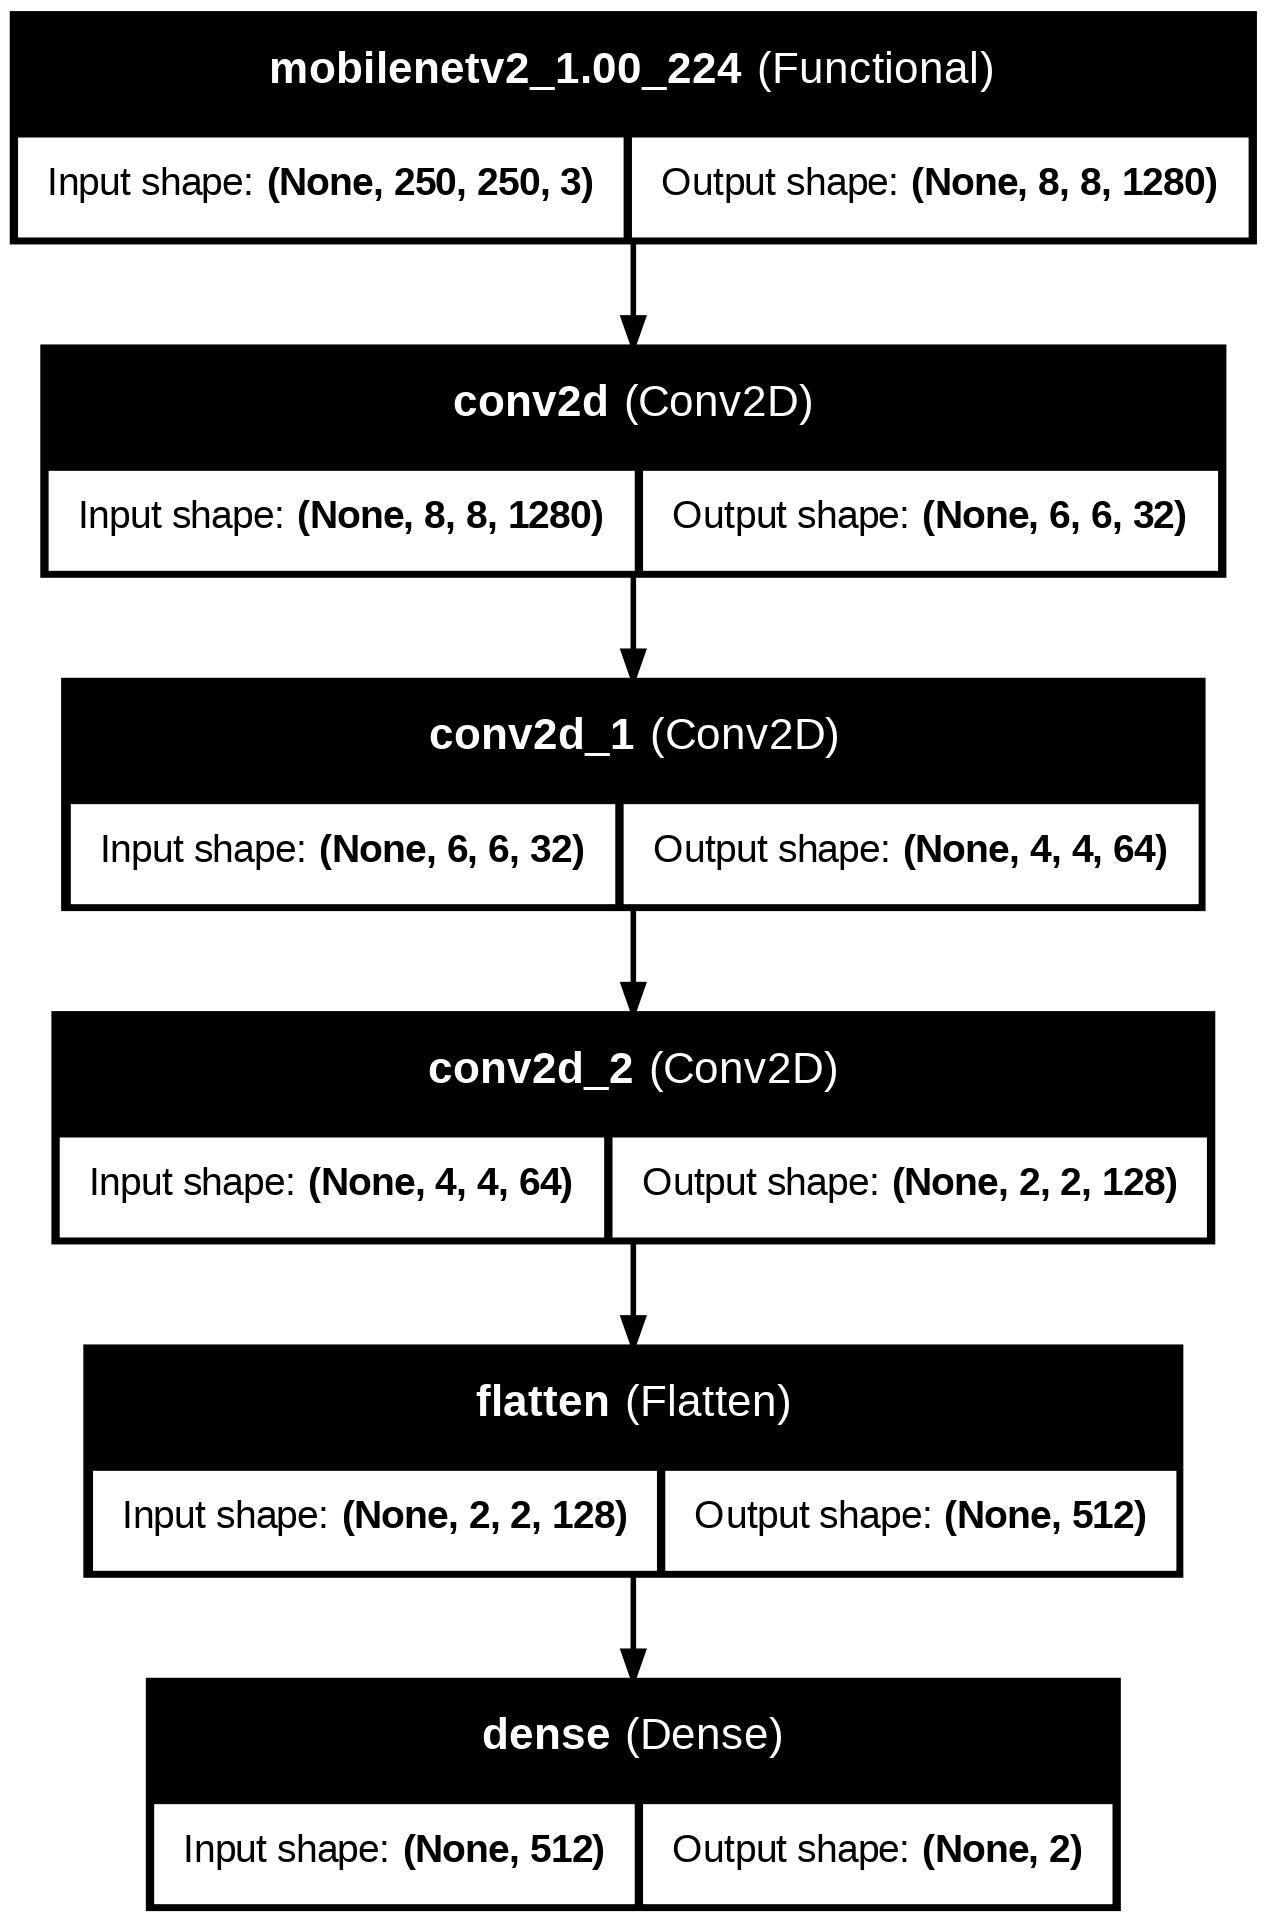

In [34]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

And thats all! We've successfully creating a model with an accuracy of around 90%. Notice that this can be further improved by performing image manipulation, performing pooling and training our model for a longer epoch or even adding more layers.. However, for our use case, this model we created is perfectly fine.  

In [35]:
print(class_names)

['Accident', 'Non Accident']


# Testing Model on Videos  
In order to use our model on a video, which is our expected use case of a CCTV footage, we will have to use OpenCV in order get the individual frames.  
Lets define a function which takes in each frame and converts it into a tensor and then predicts the output class.

In [36]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")


The following code below makes use of OpenCV. Firstly, we read the video in and grab every 20th frame(in order to reduce total computation for this demonstration) and then we can resize the image and run our function on it.  
We'll store the label and the image in a list which we can easily access.

In [37]:
import cv2
image=[]
label=[]

c=1
cap= cv2.VideoCapture('/kaggle/input/cctvfootagevideo/videoplayback (online-video-cutter.com).mp4')
while True:
    grabbed, frame = cap.read()
    if c%30==0:
        print(c)
        resized_frame=tf.keras.preprocessing.image.smart_resize(frame, (img_height, img_width), interpolation='bilinear')
        image.append(frame)
        label.append(predict_frame(resized_frame))
        if(len(image)==75):
            break
    c+=1

cap.release()

30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
210
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
630
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/

Lets see any random frame and see what the outcome is...

Accident Detected
AxesImage(shape=(360, 640, 3))


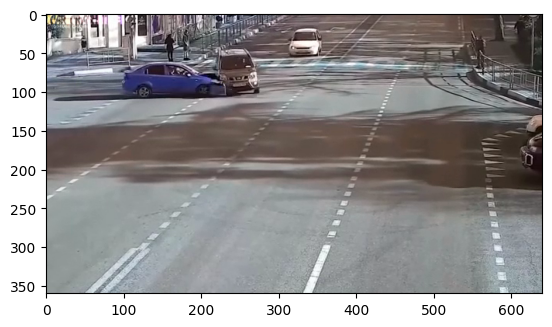

In [41]:
print(label[1])
print(plt.imshow(image[1]))

Looks about right! There seems to be an accident occuring in this frame. Our model generalizes well and can be used for practical applications.

# Converting to TFLite Model  
While we've made our model, it is true that Tensor Flow models are very large and bulky and not suitable for the small processing powers that a CCTV surveillance system will handle. For this purpose, we'll convert our Tf model into a TFLite model through the API's available by keras.

In [42]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('tf_lite_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp8tq6137w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134707036789392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036794384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036796688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036794576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036794000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036794192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036796880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036797456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036798032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134707036796304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1347070367

A TFLite model is referred to as an interpreter. We open it up and have a look at the input and output shape. It should be a single image of height and width 250 by 250 with 3 colour channels.  
The output can be of 2 types only. Accident or Non Accident.

In [43]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


While the steps below aren't necessary, I'll still show you incase you have to perform a similair task for a different model where the input tensor might change or be different.

In [44]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 250, 250,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


# Trying Our TFLite Model Out  
We'll try our TFLite model on a random image and see what our output is and if it works.

In [48]:
from PIL import Image
im=Image.open("/kaggle/input/accident-detection-from-cctv-footage/data/train/Non Accident/5_15.jpg").resize((250,250))
img_array = tf.keras.utils.img_to_array(im)
img_batch = np.expand_dims(img_array, axis=0)

The below lines are equivalent to performing a prediction in a TF model. *interpretor.get_tensor(*) performs the prediction.

Prediction results: 0.9999974
AxesImage(shape=(250, 250, 3))


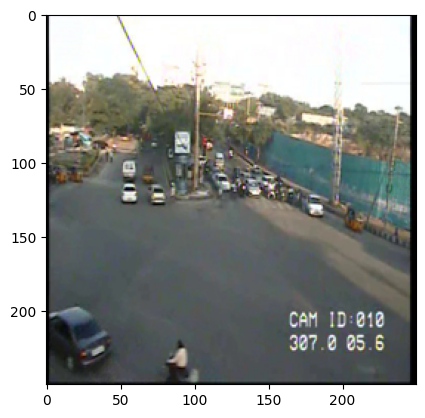

In [49]:
interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", tflite_model_predictions[0][1])
print(plt.imshow(im))

It works. We've got a complete end to end system for accident detection now that should work very well indeed.